In [79]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib
import mapie
# Package to implement ML Algorithms
import sklearn
from xgboost import XGBRegressor

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

In [80]:
df = pd.read_csv('Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   date_time       48204 non-null  object 
 7   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


In [82]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [83]:
#df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
#df['day'] = df['date_time'].dt.day
df['weekday']=df['date_time'].dt.day_of_week
df['hour'] = df['date_time'].dt.hour
df['holiday'] = df['holiday'].fillna('None').apply(lambda x: 0 if x == 'None' else 1)


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   holiday         48204 non-null  int64         
 1   temp            48204 non-null  float64       
 2   rain_1h         48204 non-null  float64       
 3   snow_1h         48204 non-null  float64       
 4   clouds_all      48204 non-null  int64         
 5   weather_main    48204 non-null  object        
 6   date_time       48204 non-null  datetime64[ns]
 7   traffic_volume  48204 non-null  int64         
 8   month           48204 non-null  int32         
 9   weekday         48204 non-null  int32         
 10  hour            48204 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(3), object(1)
memory usage: 3.5+ MB


In [85]:
df = df.drop('date_time', axis=1)

In [86]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,weekday,hour
0,0,288.28,0.0,0.0,40,Clouds,5545,10,1,9
1,0,289.36,0.0,0.0,75,Clouds,4516,10,1,10
2,0,289.58,0.0,0.0,90,Clouds,4767,10,1,11
3,0,290.13,0.0,0.0,90,Clouds,5026,10,1,12
4,0,291.14,0.0,0.0,75,Clouds,4918,10,1,13


In [87]:
# Select input and output features
X = df.drop(columns = ['traffic_volume'])
y = df['traffic_volume']

In [88]:
# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)
X_encoded.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,month,weekday,hour,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,0,288.28,0.0,0.0,40,10,1,9,False,True,False,False,False,False,False,False,False,False,False
1,0,289.36,0.0,0.0,75,10,1,10,False,True,False,False,False,False,False,False,False,False,False
2,0,289.58,0.0,0.0,90,10,1,11,False,True,False,False,False,False,False,False,False,False,False
3,0,290.13,0.0,0.0,90,10,1,12,False,True,False,False,False,False,False,False,False,False,False
4,0,291.14,0.0,0.0,75,10,1,13,False,True,False,False,False,False,False,False,False,False,False


In [89]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

In [90]:
print("Training Features:", train_X.columns)

Training Features: Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'month',
       'weekday', 'hour', 'weather_main_Clear', 'weather_main_Clouds',
       'weather_main_Drizzle', 'weather_main_Fog', 'weather_main_Haze',
       'weather_main_Mist', 'weather_main_Rain', 'weather_main_Smoke',
       'weather_main_Snow', 'weather_main_Squall',
       'weather_main_Thunderstorm'],
      dtype='object')


In [91]:
model = XGBRegressor()

In [92]:
model.fit(train_X,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
# Predict Test Set
y_pred = model.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 429.74


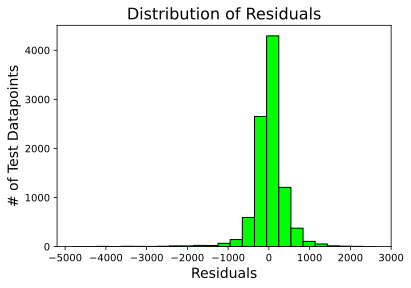

In [105]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("residual_plot.svg", bbox_inches ='tight')

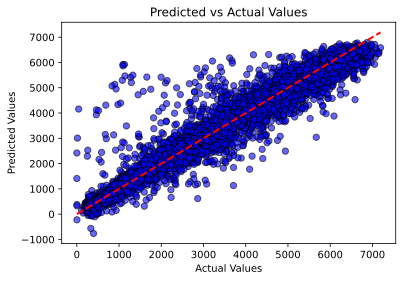

In [95]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("pred_vs_actual.svg", bbox_inches ='tight')

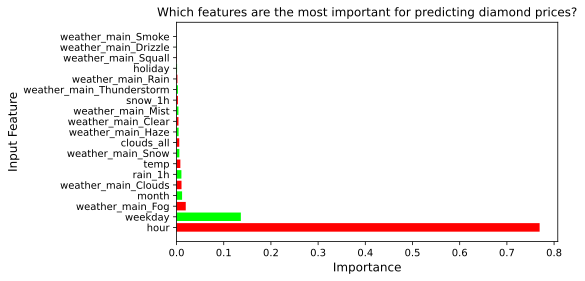

In [96]:
# Storing importance values from the trained model
importance = model.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting diamond prices?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();
plt.savefig("feature_imp.svg", bbox_inches ='tight')

In [97]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = model, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")



Training time: 6.49649977684021s


In [98]:
alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

In [99]:
# Predicted values
y_test_pred

array([5971.9795 , 2139.5432 ,  728.83093, ..., 1958.5402 , 2966.3027 ,
        608.14453], dtype=float32)

In [100]:
# Prediction Intervals
y_test_pis

array([[[5229.84619141],
        [6392.15820312]],

       [[1638.02612305],
        [2790.17199707]],

       [[ 154.71643066],
        [1301.17651367]],

       ...,

       [[1445.23596191],
        [2612.20092773]],

       [[2315.69439697],
        [3473.3046875 ]],

       [[  47.3112793 ],
        [1191.84436035]]])

In [101]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,2780.770020,2106.22,3262.60
34004,5251,5218.700195,4682.69,5823.34
46086,2224,1958.540039,1445.24,2612.20
42579,2928,2966.300049,2315.69,3473.30
23709,910,608.140015,47.31,1191.84


In [102]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.82%


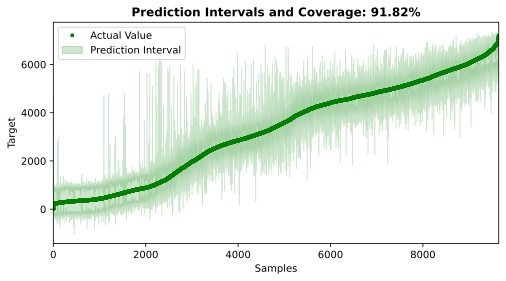

In [103]:
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig("coverage.svg", bbox_inches ='tight')

In [104]:
# Creating the file where we want to write the model
reg_pickle = open('reg_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()